In [0]:
!nvcc --version
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Saving gpu.cu to gpu.cu
Saving gpu.h to gpu.h
Saving main.c to main.c


,GPU time (s),CPU time
8,0.06926,0.00000
16,0.05644,0.00000
32,0.05753,0.00001
64,0.05672,0.00001
128,0.05695,0.00003
256,0.06112,0.00009
512,0.05759,0.00016
1024,0.05816,0.00035
2048,0.05887,0.00075
4096,0.05663,0.00172


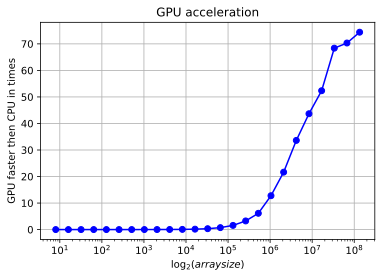

In [88]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython.display import set_matplotlib_formats, display
from matplotlib import pyplot as plt
from google.colab import files
import numpy as np
import pandas as pd
import subprocess
import os
import re

if (os.path.exists('/content/Bitonic sort') == False):
    os.mkdir('Bitonic sort')
os.chdir('/content/Bitonic sort/')
if (os.path.exists('/content/Bitonic sort/gpu.cu') == True):
    os.remove('/content/Bitonic sort/gpu.cu')
if (os.path.exists('/content/Bitonic sort/gpu.h') == True):
    os.remove('/content/Bitonic sort/gpu.h')
if (os.path.exists('/content/Bitonic sort/main.c') == True):
    os.remove('/content/Bitonic sort/main.c')
uploaded = files.upload()

subprocess.Popen('nvcc main.c gpu.cu -o main', shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT).wait()

data_x = [2 ** i for i in range(3, 28)]
data_time = []
data_speedUp = []

for x in data_x:
    p = subprocess.Popen('./main ' + str(x), shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    retval = p.wait()
    poutput = p.stdout.read().decode("utf-8")
    timings = [float(x) for x in re.findall("\d+\.\d+", poutput)]
    data_time.append(timings)
    data_speedUp.append(timings[1] / timings[0])

display(pd.DataFrame(data=data_time, index=data_x, columns=["GPU time (s)", "CPU time "]))

plt.grid()
plt.xscale('log')
plt.yscale('linear')
plt.xlabel(r'$\log_2 (array size)$')
plt.ylabel('GPU faster then CPU in times')
plt.title('GPU acceleration')
plt.plot(data_x, data_speedUp, color='blue', marker='o', label='СPU time / GPU time');